In [1]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

2023-08-27 20:48:02.814897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 20:48:03.853978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Large data set

In [2]:
model = tf.keras.models.load_model('models/large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})

2023-08-27 20:48:06.046764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 20:48:06.267088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 20:48:06.267305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [4]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [6]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)


In [7]:
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

In [8]:
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


181/181 [==============================] - 0s 799us/step


In [70]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om)+19)

In [71]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(5785, 5785, 5785)

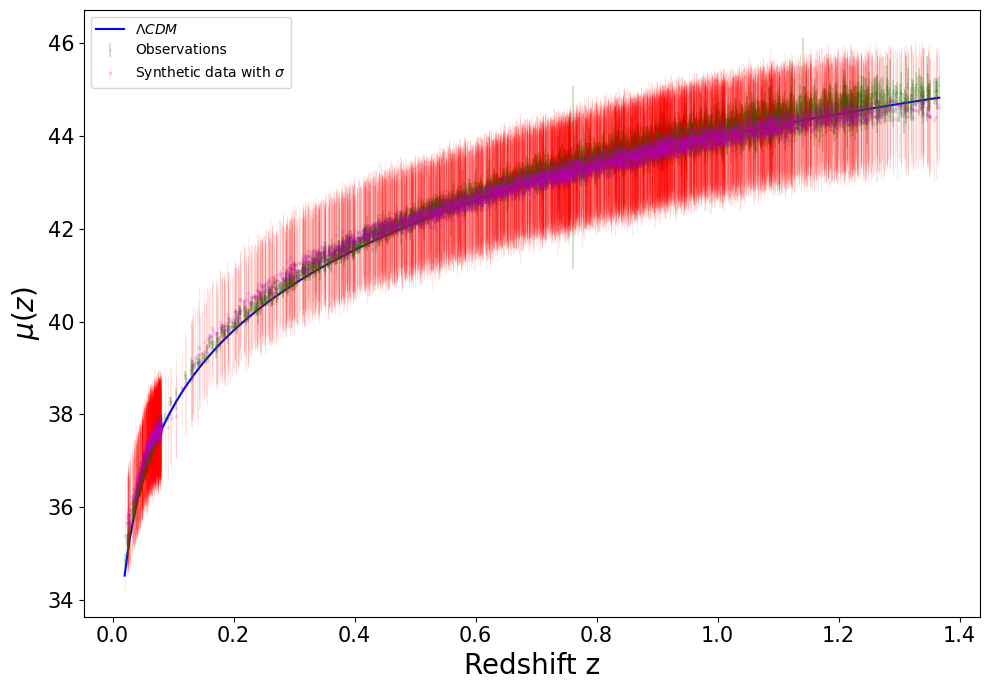

In [72]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m',
             label='Synthetic data with $\sigma$')

# plt.xlim(zmin-0.01,zmax+0.01)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [73]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values, flcdm)
mse_neural = mean_squared_error(df_data['MU'].values, np.sort(prediction_mc_dropout[:,0]-19))
mse_lcdm, mse_neural

(0.038229351086070555, 363.4191301916147)

In [74]:
np.sort(prediction_mc_dropout[:,0])

array([35.37578835, 35.60089062, 35.64245445, ..., 44.80164062,
       44.87973869, 44.88679211])

In [75]:
np.sort(df_data['MU'].values)

array([34.8468 , 34.89863, 35.09582, ..., 45.24313, 45.33098, 45.43075])

### ToDo: Check the constant to sum

/tmp/ipykernel_48821/4123556303.py:33: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25


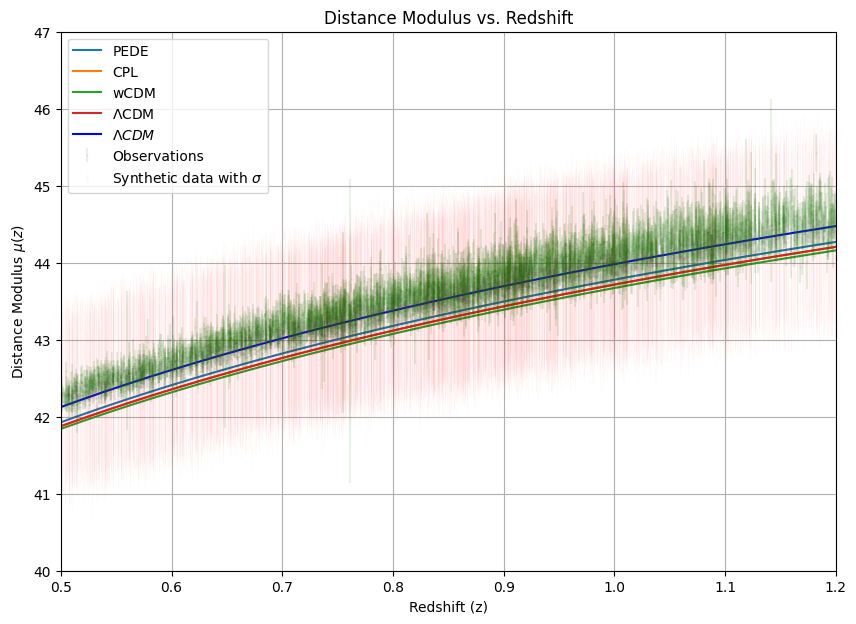

In [92]:
# Functions for PEDE model
def H_z_PEDE(z, H0, Omega_m0, Omega_DE0):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 - np.tanh(np.log10(1 + z)))
    return H0 * np.sqrt(term1 + term2)

# Functions for CPL model
def w_CPL(z, w0, wa):
    return w0 + wa * z / (1 + z)

def H_z_CPL(z, H0, Omega_m0, Omega_DE0, w0, wa):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w_CPL(z, w0, wa)))
    return H0 * np.sqrt(term1 + term2)

# Functions for wCDM model
def H_z_wCDM(z, H0, Omega_m0, Omega_DE0, w):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w))
    return H0 * np.sqrt(term1 + term2)

def luminosity_distance(z, H0, Omega_m0, Omega_DE0, model='PEDE', w0=None, wa=None, w=None):
    if model == 'PEDE':
        integral, _ = quad(lambda z_prime: 1/H_z_PEDE(z_prime, H0, Omega_m0, Omega_DE0), 0, z)
    elif model == 'CPL':
        integral, _ = quad(lambda z_prime: 1/H_z_CPL(z_prime, H0, Omega_m0, Omega_DE0, w0, wa), 0, z)
    elif model == 'wCDM':
        integral, _ = quad(lambda z_prime: 1/H_z_wCDM(z_prime, H0, Omega_m0, Omega_DE0, w), 0, z)
    return (1 + z) * integral

def mu(z, H0, Omega_m0, Omega_DE0, model='PEDE', w0=None, wa=None, w=None):
    dL = luminosity_distance(z, H0, Omega_m0, Omega_DE0, model, w0, wa, w)
    return 5 * np.log10(dL) + 25

# Parameters
H0 = 70  # Hubble constant in km/s/Mpc
Omega_m0 = 0.3  # Example value for matter density today
Omega_DE0 = 0.7  # Example value for dark energy density today
w0 = -1.0  # Example value for w0 in CPL model
wa = 0.0  # Example value for wa in CPL model
w = -0.9  # Example value for w in wCDM model

# Create an array of redshift values
z_values = np.linspace(0, 1.2, 100)
mu_PEDE_values = [mu(z, H0, Omega_m0, Omega_DE0, model='PEDE')+27 for z in z_values]
mu_CPL_values = [mu(z, H0, Omega_m0, Omega_DE0, model='CPL', w0=w0, wa=wa)+27 for z in z_values]
mu_wCDM_values = [mu(z, H0, Omega_m0, Omega_DE0, model='wCDM', w=w)+27 for z in z_values]
mu_LambdaCDM_values = [mu(z, H0, Omega_m0, Omega_DE0, model='wCDM', w=-1)+27 for z in z_values]


# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.plot(z_values, mu_PEDE_values, label='PEDE')
plt.plot(z_values, mu_CPL_values, label='CPL')
plt.plot(z_values, mu_wCDM_values, label='wCDM')
plt.plot(z_values, mu_LambdaCDM_values, label='$\Lambda$CDM')


# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.1, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.015, c='m',
             label='Synthetic data with $\sigma$')


plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus $\mu(z)$')
plt.title('Distance Modulus vs. Redshift')
plt.legend()
plt.xlim(0.5,1.2)
plt.ylim(40,47)
plt.grid(True)
plt.show()
